<a href="https://colab.research.google.com/github/xkumachii/pneumonia/blob/main/Pneumonia_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.53.228.242:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.53.228.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.53.228.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


In [3]:
! pip install -q kaggle
from google.colab import files

In [4]:
# 1.) check your kaggle account 
# 2.) go to edit profile
# 3.) create a new api token
# 4.) upload your kaggle.json file here
# 5.) for any retesting, keep your json file, and do not regenerate your api token unless absolutely needed
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kumachii","key":"f54f1492a39626e5e7bc3b112a34c56b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:23<00:00, 149MB/s]
100% 2.29G/2.29G [00:23<00:00, 105MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile("chest-xray-pneumonia.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

# Summary of our data set

This notebook will demonstrate the diagnosis of pneumonia, and different types of pneumonia using various kinds of Convolutional Neural Networks. We will be using our own simple CNN to start off each section. Afterwards, we will be using VGG16, and Xception, and freezing various layers in order to test their classifying efficacy. 

The dataset we are working with is of various X-ray images of Chinese pediatric patients' lungs, sourced from Kaggle. There is a significant imbalance in our training data set, so we will be using various balancing techniques.

# Binary Classification

## Loading our data

In [7]:
def load_data(path):

  imgs = []
  labels = np.array([])
  filenames = np.array([])

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      # To reduce training costs, the images are resized to 200x200.
      img = image.load_img(temp_path + "/" + f, target_size=(300,300))
      x = image.img_to_array(img)
      imgs.append(x)
      labels = np.append(labels, [int(dir == 'PNEUMONIA')])

      filenames = np.append(filenames, temp_path + "/" + f)

      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1
   

  imgs = np.asarray(imgs)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels, filenames

In [8]:
X_train, y_train, train_files = load_data("/content/files/chest_xray/train")
X_test, y_test, test_files = load_data("/content/files/chest_xray/test")

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 300, 300, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 300, 300, 3)


In [9]:
print(train_files[[1, 2, 3, 4, 5]])

['/content/files/chest_xray/train/NORMAL/NORMAL2-IM-0995-0001-0001.jpeg'
 '/content/files/chest_xray/train/NORMAL/IM-0615-0001.jpeg'
 '/content/files/chest_xray/train/NORMAL/NORMAL2-IM-0414-0001.jpeg'
 '/content/files/chest_xray/train/NORMAL/IM-0542-0001.jpeg'
 '/content/files/chest_xray/train/NORMAL/IM-0661-0001.jpeg']


##Simple CNN

In [75]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        1

### training

In [76]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = {0:class_weight[0], 1:class_weight[1]}

batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)

history = model.fit(gen_data,steps_per_epoch=len(gen_data),epochs=20,callbacks=callback,validation_data=gen_test,validation_steps=len(gen_test),class_weight=class_weights)

Epoch 1/20
163/163 [==============================] - 95s 582ms/step - loss: 0.6543 - accuracy: 0.6254 - val_loss: 0.6155 - val_accuracy: 0.7484
Epoch 2/20
163/163 [==============================] - 93s 573ms/step - loss: 0.4682 - accuracy: 0.7766 - val_loss: 0.5450 - val_accuracy: 0.7676
Epoch 3/20
163/163 [==============================] - 93s 571ms/step - loss: 0.4279 - accuracy: 0.8140 - val_loss: 0.4091 - val_accuracy: 0.8221
Epoch 4/20
163/163 [==============================] - 93s 572ms/step - loss: 0.3826 - accuracy: 0.8441 - val_loss: 0.4020 - val_accuracy: 0.8446
Epoch 5/20
163/163 [==============================] - 91s 556ms/step - loss: 0.3640 - accuracy: 0.8602 - val_loss: 0.3208 - val_accuracy: 0.8638
Epoch 6/20
163/163 [==============================] - 90s 553ms/step - loss: 0.3602 - accuracy: 0.8637 - val_loss: 0.3650 - val_accuracy: 0.8317


### heatmaps

In [77]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array /= 255
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def superimposition(img_path, heatmap):
  # We load the original image
  img = image.load_img(img_path)
  img = image.img_to_array(img)

  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "elephant_cam.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  display(Image(save_path))

In [78]:
np.random.seed(42)

normal_indices = np.array([i == 0 for i in y_test])
pneumonia_indices = np.array([i == 1 for i in y_test])

test_normal_files = test_files[normal_indices]
test_pneumonia_files = test_files[pneumonia_indices]

test_normal_sample_indices = np.random.choice(test_normal_files.shape[0], 25)
test_normal_sample_files = test_normal_files[test_normal_sample_indices]

test_pneumonia_sample_indices = np.random.choice(test_pneumonia_files.shape[0], 25)
test_pneumonia_sample_files = test_pneumonia_files[test_pneumonia_sample_indices]

In [93]:
pneumonia_preds_array = np.array([])
for i in test_pneumonia_sample_files:
  img_path = i

  # preds = model.predict(np.expand_dims(X_test[340], axis=0))

  img = image.load_img(img_path, target_size=(300,300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x
  # print(img)

  preds = model.predict(img)[0][0]
  pneumonia_preds_array = np.append(pneumonia_preds_array, preds)
  print("Predicted:", (preds))

Predicted: 0.9080636
Predicted: 0.9125284
Predicted: 0.8815423
Predicted: 0.6631255
Predicted: 0.83379716
Predicted: 0.9554403
Predicted: 0.7707134
Predicted: 0.24069577
Predicted: 0.77696204
Predicted: 0.92832005
Predicted: 0.7839157
Predicted: 0.35320067
Predicted: 0.8271661
Predicted: 0.34924796
Predicted: 0.41213334
Predicted: 0.55970836
Predicted: 0.5953404
Predicted: 0.37242612
Predicted: 0.8285107
Predicted: 0.3835902
Predicted: 0.6599366
Predicted: 0.9197812
Predicted: 0.8159382
Predicted: 0.79594654
Predicted: 0.73624116


In [94]:
normal_preds_array = np.array([])
for i in test_normal_sample_files:
  img_path = i

  # preds = model.predict(np.expand_dims(X_test[340], axis=0))

  img = image.load_img(img_path, target_size=(300,300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x
  # print(img)

  preds = model.predict(img)[0][0]
  normal_preds_array = np.append(normal_preds_array, preds)
  print("Predicted:", (preds))

Predicted: 0.12609315
Predicted: 0.15261404
Predicted: 0.17268036
Predicted: 0.11934501
Predicted: 0.102283806
Predicted: 0.2773893
Predicted: 0.12757803
Predicted: 0.14420891
Predicted: 0.12609315
Predicted: 0.23530747
Predicted: 0.20680667
Predicted: 0.14192972
Predicted: 0.30138096
Predicted: 0.085752465
Predicted: 0.18148807
Predicted: 0.121165805
Predicted: 0.31775063
Predicted: 0.114700824
Predicted: 0.14055203
Predicted: 0.16497196
Predicted: 0.092358775
Predicted: 0.07452093
Predicted: 0.14370167
Predicted: 0.18148807
Predicted: 0.8623399


In [95]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array /= 255
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def superimposition(img_path, heatmap):
  # We load the original image
  img = image.load_img(img_path)
  img = image.img_to_array(img)

  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "xray.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  display(Image(save_path))

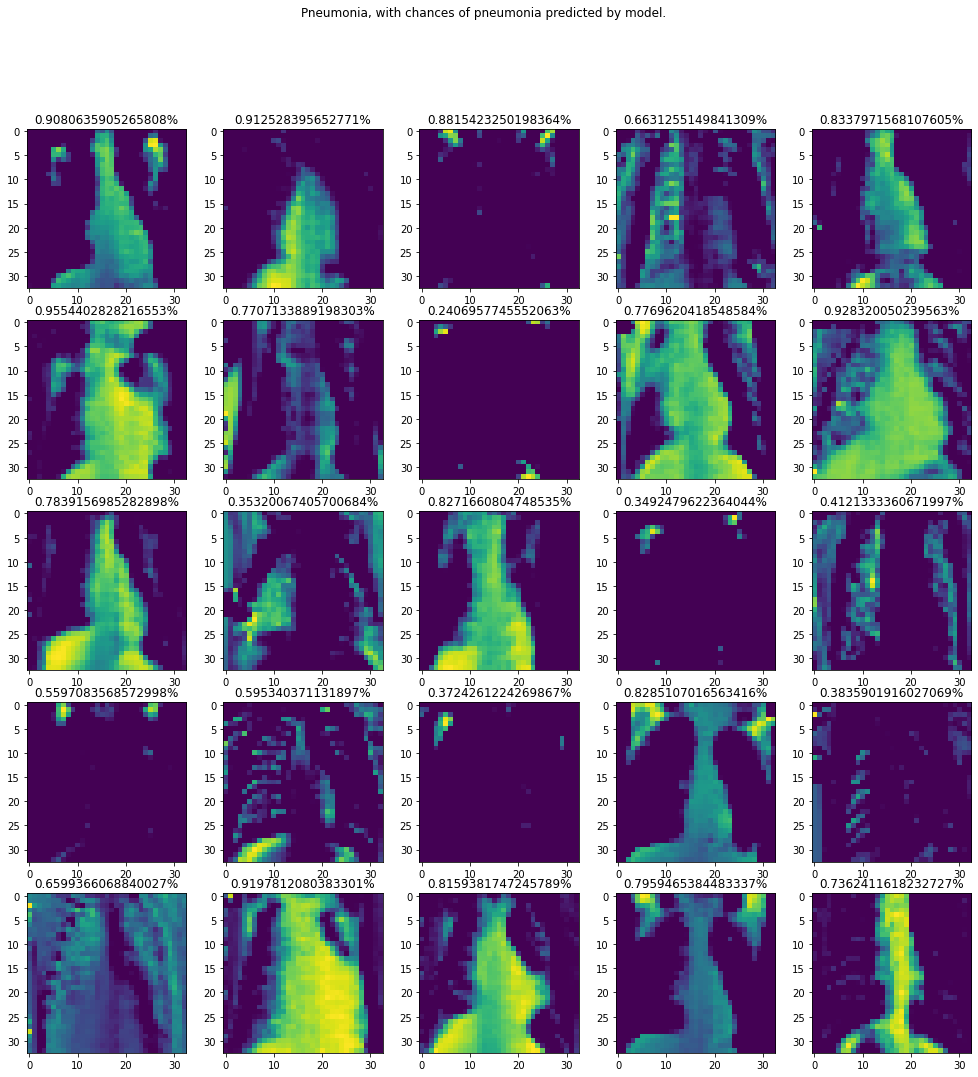

In [96]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

heatmaps = []

for i in test_pneumonia_sample_files:
  img_path = i
  img_array = get_img_array(img_path, size=(300,300))

  heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)
  heatmaps.append(heatmap)
  
f, axarr = plt.subplots(5,5,figsize=(17, 17))
f.suptitle('Pneumonia, with chances of pneumonia predicted by model.')
# row 1
axarr[0,0].imshow(heatmaps[0])
axarr[0,0].set_title(str(pneumonia_preds_array[0]) + "%")
axarr[0,1].imshow(heatmaps[1])
axarr[0,1].set_title(str(pneumonia_preds_array[1]) + "%")
axarr[0,2].imshow(heatmaps[2])
axarr[0,2].set_title(str(pneumonia_preds_array[2]) + "%")
axarr[0,3].imshow(heatmaps[3])
axarr[0,3].set_title(str(pneumonia_preds_array[3]) + "%")
axarr[0,4].imshow(heatmaps[4])
axarr[0,4].set_title(str(pneumonia_preds_array[4]) + "%")

# row 2
axarr[1,0].imshow(heatmaps[5])
axarr[1,0].set_title(str(pneumonia_preds_array[5]) + "%")
axarr[1,1].imshow(heatmaps[6])
axarr[1,1].set_title(str(pneumonia_preds_array[6]) + "%")
axarr[1,2].imshow(heatmaps[7])
axarr[1,2].set_title(str(pneumonia_preds_array[7]) + "%")
axarr[1,3].imshow(heatmaps[8])
axarr[1,3].set_title(str(pneumonia_preds_array[8]) + "%")
axarr[1,4].imshow(heatmaps[9])
axarr[1,4].set_title(str(pneumonia_preds_array[9]) + "%")

# row 3
axarr[2,0].imshow(heatmaps[10])
axarr[2,0].set_title(str(pneumonia_preds_array[10]) + "%")
axarr[2,1].imshow(heatmaps[11])
axarr[2,1].set_title(str(pneumonia_preds_array[11]) + "%")
axarr[2,2].imshow(heatmaps[12])
axarr[2,2].set_title(str(pneumonia_preds_array[12]) + "%")
axarr[2,3].imshow(heatmaps[13])
axarr[2,3].set_title(str(pneumonia_preds_array[13]) + "%")
axarr[2,4].imshow(heatmaps[14])
axarr[2,4].set_title(str(pneumonia_preds_array[14]) + "%")

# row 4
axarr[3,0].imshow(heatmaps[15])
axarr[3,0].set_title(str(pneumonia_preds_array[15]) + "%")
axarr[3,1].imshow(heatmaps[16])
axarr[3,1].set_title(str(pneumonia_preds_array[16]) + "%")
axarr[3,2].imshow(heatmaps[17])
axarr[3,2].set_title(str(pneumonia_preds_array[17]) + "%")
axarr[3,3].imshow(heatmaps[18])
axarr[3,3].set_title(str(pneumonia_preds_array[18]) + "%")
axarr[3,4].imshow(heatmaps[19])
axarr[3,4].set_title(str(pneumonia_preds_array[19]) + "%")

# row 5
axarr[4,0].imshow(heatmaps[20])
axarr[4,0].set_title(str(pneumonia_preds_array[20]) + "%")
axarr[4,1].imshow(heatmaps[21])
axarr[4,1].set_title(str(pneumonia_preds_array[21]) + "%")
axarr[4,2].imshow(heatmaps[22])
axarr[4,2].set_title(str(pneumonia_preds_array[22]) + "%")
axarr[4,3].imshow(heatmaps[23])
axarr[4,3].set_title(str(pneumonia_preds_array[23]) + "%")
axarr[4,4].imshow(heatmaps[24])
axarr[4,4].set_title(str(pneumonia_preds_array[24]) + "%");



We can see that the more certainly our model predicts a pneumonia case, the more it tends to focus on the lungs.

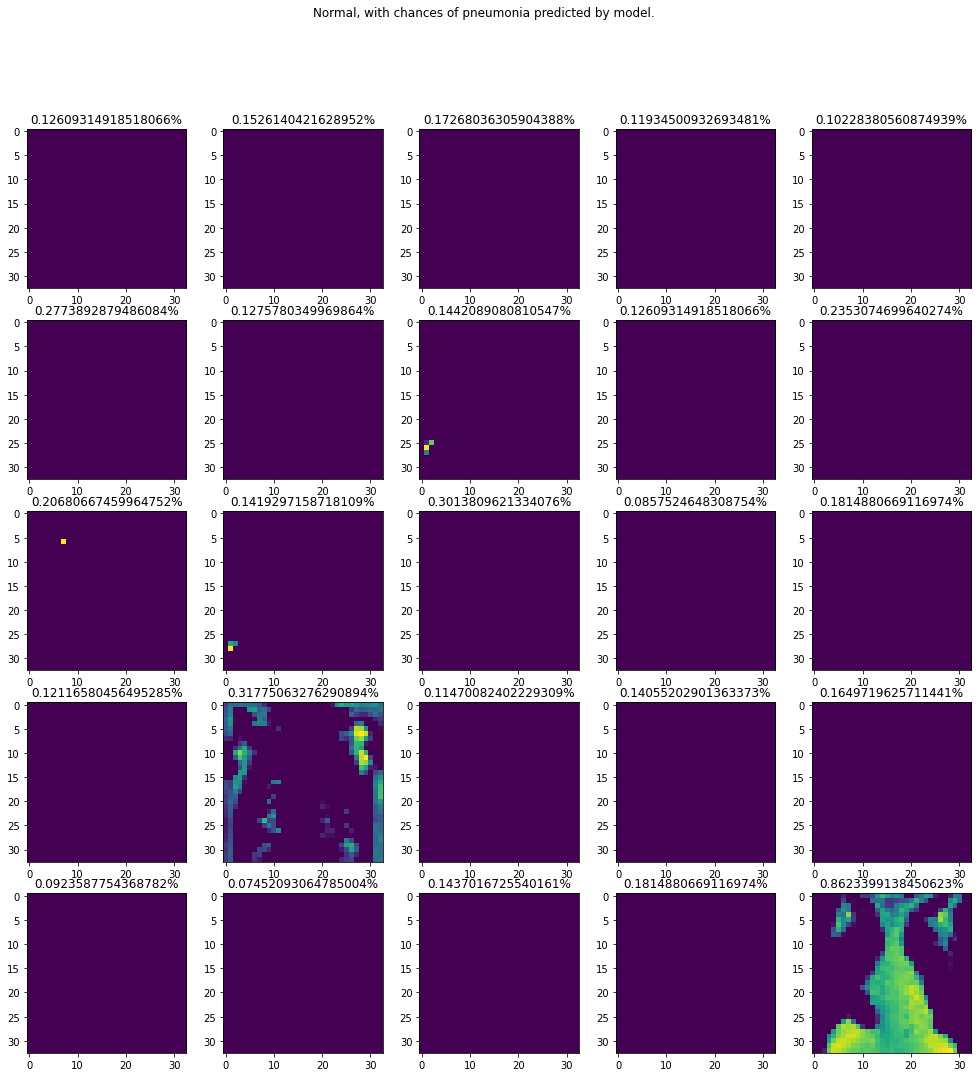

In [88]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

heatmaps = []

for i in test_normal_sample_files:
  img_path = i
  img_array = get_img_array(img_path, size=(300,300))

  heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)
  heatmaps.append(heatmap)
  
f, axarr = plt.subplots(5,5,figsize=(17, 17))
f.suptitle('Normal, with chances of pneumonia predicted by model.')
# row 1
axarr[0,0].imshow(heatmaps[0])
axarr[0,0].set_title(str(normal_preds_array[0]) + "%")
axarr[0,1].imshow(heatmaps[1])
axarr[0,1].set_title(str(normal_preds_array[1]) + "%")
axarr[0,2].imshow(heatmaps[2])
axarr[0,2].set_title(str(normal_preds_array[2]) + "%")
axarr[0,3].imshow(heatmaps[3])
axarr[0,3].set_title(str(normal_preds_array[3]) + "%")
axarr[0,4].imshow(heatmaps[4])
axarr[0,4].set_title(str(normal_preds_array[4]) + "%")

# row 2
axarr[1,0].imshow(heatmaps[5])
axarr[1,0].set_title(str(normal_preds_array[5]) + "%")
axarr[1,1].imshow(heatmaps[6])
axarr[1,1].set_title(str(normal_preds_array[6]) + "%")
axarr[1,2].imshow(heatmaps[7])
axarr[1,2].set_title(str(normal_preds_array[7]) + "%")
axarr[1,3].imshow(heatmaps[8])
axarr[1,3].set_title(str(normal_preds_array[8]) + "%")
axarr[1,4].imshow(heatmaps[9])
axarr[1,4].set_title(str(normal_preds_array[9]) + "%")

# row 3
axarr[2,0].imshow(heatmaps[10])
axarr[2,0].set_title(str(normal_preds_array[10]) + "%")
axarr[2,1].imshow(heatmaps[11])
axarr[2,1].set_title(str(normal_preds_array[11]) + "%")
axarr[2,2].imshow(heatmaps[12])
axarr[2,2].set_title(str(normal_preds_array[12]) + "%")
axarr[2,3].imshow(heatmaps[13])
axarr[2,3].set_title(str(normal_preds_array[13]) + "%")
axarr[2,4].imshow(heatmaps[14])
axarr[2,4].set_title(str(normal_preds_array[14]) + "%")

# row 4
axarr[3,0].imshow(heatmaps[15])
axarr[3,0].set_title(str(normal_preds_array[15]) + "%")
axarr[3,1].imshow(heatmaps[16])
axarr[3,1].set_title(str(normal_preds_array[16]) + "%")
axarr[3,2].imshow(heatmaps[17])
axarr[3,2].set_title(str(normal_preds_array[17]) + "%")
axarr[3,3].imshow(heatmaps[18])
axarr[3,3].set_title(str(normal_preds_array[18]) + "%")
axarr[3,4].imshow(heatmaps[19])
axarr[3,4].set_title(str(normal_preds_array[19]) + "%")

# row 5
axarr[4,0].imshow(heatmaps[20])
axarr[4,0].set_title(str(normal_preds_array[20]) + "%")
axarr[4,1].imshow(heatmaps[21])
axarr[4,1].set_title(str(normal_preds_array[21]) + "%")
axarr[4,2].imshow(heatmaps[22])
axarr[4,2].set_title(str(normal_preds_array[22]) + "%")
axarr[4,3].imshow(heatmaps[23])
axarr[4,3].set_title(str(normal_preds_array[23]) + "%")
axarr[4,4].imshow(heatmaps[24])
axarr[4,4].set_title(str(normal_preds_array[24]) + "%");


On the other hand, the model, when unsure if some case has pneumonia, does not focus much in one area of the lungs.

## VGG16 Transfer Learning

### training

### heatmaps

## XCeption

### training

## heatmaps

# Three-way Classification

## Loading our data

In [ ]:
# prepare three-way categorical data for training
%cd files/chest_xray/train
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
!ls

# prepare three-way categorical data for training
%cd ../test
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
%cd ../../..

## Simple CNN

### training

### heatmaps

## VGG-16

### training

### heatmaps

## XCeption

### training

### heatmaps


# Conclusions